In [1]:
from scipy import stats
import pandas as pd
import numpy as np
import os
import seaborn as sns   
import matplotlib.pyplot as plt  
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from uszipcode import SearchEngine
from functools import lru_cache
from sklearn.metrics import (
    make_scorer,
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
   precision_recall_curve,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
sns.set(color_codes=True) # adds a nice background to the graphs
DEFAULT_CLASSIFICATION_THRESHOLD = 0.5

In [2]:
@lru_cache
def search_by_zipcode()->SearchEngine:
    """Get the search engine to search by the county."""
    return SearchEngine(simple_zipcode=True)

def load_dataframe_from_csv(csv_file_name:str)->pd.DataFrame: 
    """Load a csv file and return a pandas dataframe.

    Parameters
    ----------
    csv_file_name : str
        The csv file

    Return
    ------
    data_frame : DataFrame
        Pandas data frame

    Raises
    ------
    AssertionError
        If the file type is not of type csv
    """

    file_name = str(csv_file_name)
    _,file_type=os.path.splitext(file_name)
    assert file_type == '.csv',f"File format should be of type csv instead of format {file_type}"

    data_frame = pd.read_csv(csv_file_name)
    return data_frame

def print_frame_meta_info(data_frame:pd.DataFrame): 
    """Load a data frame file and print meta info of the data frame.

    Parameters
    ----------
    data_frame : DataFrame
    """
    rows,columns = np.shape(data_frame)
    print(f"Shape of the data frame is: {rows},{columns}")
    print(f"Number of variables are: {columns}")
    print("Memory Usage:"+str(data_frame.memory_usage(index=False,deep=True).sum()*0.001))
    print("")
    print("")

    
    for column in data_frame.columns:
        print(f"Name of the column: {column}")
            
        data_in_column = data_frame[column]
            
        metadata_column = [element for element in data_in_column.notna()]
        number_missing = metadata_column.count(False)
        
        number_unique_values = len(np.unique(data_in_column))
        
        print("Number of missing values:"+str(number_missing))
        percent_missing = ((number_missing)/len(data_in_column))*100.0
        print("% of missing values:"+str(percent_missing))
        print("Memory Usage:"+str(data_in_column.memory_usage()*0.001))
        print("Number of unique values:"+str(number_unique_values))
        print("")


def get_county_for_zipcode(zip_code : int)->str:
    """Take in a zipcode and return the correponding county name 
    for that zipcode.

    Parameters
    ----------
    zip_code : Zip code of the county
    
    
    Return
    ------
    county : Name of the county corresponding to the zipcode.
    """
    searcher = search_by_zipcode()
    county = searcher.by_zipcode(str(zip_code)).county
    # some of the zipcodes provided does not match in USA (atleast as per the tool uszipcode)
    # we return unknown for those.
    return "unknown" if county is None else county

def get_education_level(education:int)->str:
    """Take in a education (education code) and return
    the corresponding education level

    Parameters
    ----------
    education : Education code
    
    
    Return
    ------
    education_level : Name of the education level corresponding to the education code.
    """
    if education == 1:
        return "Undergrad"
    elif education == 2:
        return "Graduate"
    elif education == 3:
        return "Advanced"
    else:
        raise ValueError(f"Got unkown education code:{education}")

def num_to_str(num:int)->str:
    """For the binary fields (like Securities_Account,CD_Account,Online and CreditCard)
    convert to "yes" (if 1) or "no" (if 0). This will help in better intepreting of the data 
    (especially during the EDA)
 
    Parameters
    ----------
    num : status of that field
    
    
    Return
    ------
    info : Info corresponding to the number provided.
    """
    if num == 1:
        return "Yes"
    elif num == 0:
        return "No"
    else:
        raise ValueError(f"Got unkown status:{num}")


def print_training_testing_meta(X_train,X_test,y_train,y_test):
    """Takes in a training and testing data (with both target and feature variables)
    and prints their metadata.
    """
    print(f"Shape of Training set : {X_train.shape}")
    print(f"Shape of test set : {X_test.shape}")
    print(f"Percentage of classes in training set:{y_train.value_counts(normalize=True)}")
    print(f"Percentage of classes in test set:{y_test.value_counts(normalize=True)}")


def print_model_performance_for_classification(model, 
                                               features, 
                                               target, 
                                               threshold=DEFAULT_CLASSIFICATION_THRESHOLD):
    """
    Print the relevant scores for a classification model

    model: the model to classify with
    features: the feature vectors
    target: our target variable to predict
    threshold: threshold to infer as belonging to lable 1.
    """
    # predicting using the independent variables
    prediction = model.predict_proba(features)[:, 1]
    prediction_threshold = prediction > threshold
    final_prediction = np.round(prediction_threshold)
    # get the scores
    accuracy = accuracy_score(target, final_prediction)  
    recall = recall_score(target, final_prediction)  
    precision = precision_score(target, final_prediction)  
    f1 = f1_score(target, final_prediction)  
    
    print(f"Accuracy:{accuracy}")
    print(f"Recall:{recall}")
    print(f"Precision: {precision}")
    print(f"F1 score: {f1}")


def plot_confusion_matrix(model, features, target, threshold=0.5):
    """
    Plot the confusion matrix for a model

    model: the model to classify with
    features: the feature vectors
    target: our target variable to predict
    threshold: threshold to infer as belonging to lable 1.
    """
    pred_prob = model.predict_proba(features)[:, 1]
    pred_thres = pred_prob > threshold
    y_pred = np.round(pred_thres)
    
    prediction = model.predict_proba(features)[:, 1]
    prediction_threshold = prediction > threshold
    output_prediction = np.round(prediction_threshold)

    cm = confusion_matrix(target, output_prediction)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels,fmt="")
    plt.ylabel("Ground truth")
    plt.xlabel("Predicted")

def plot_precision_recall_threshold(y_train,y_scores):
    """Plot the precision and recall vs the threshold score."""
    precision_scores, recall_scores, thresholds = precision_recall_curve(y_train, y_scores)
    plt.plot(thresholds, precision_scores[:-1],label="precision")
    plt.plot(thresholds, recall_scores[:-1],label="recall")
    plt.xlabel("Prediction Threshold")
    plt.legend(loc="upper right")
    plt.ylim([0, 1])
    plt.show()

def perform_pre_prunning(X_train:pd.core.frame.DataFrame,
                         y_train:pd.core.series.Series,
                         )->DecisionTreeClassifier:
    """Takes in training dataset and returns pruned decision tree classifier.
    
    Parameters
    ----------
    X_train : input features
    y_train : the target to train for
    
    
    Return
    ------
    prunned_tree : prunned_tree with the tuned parameters
    """
    decision_tree = DecisionTreeClassifier(random_state=1)
    
    # Set the desired parameters
    parameters = {'max_depth': [5,10,15,None],
                  'criterion': ['gini','entropy'],
                  'splitter': ['best','random'],             
                 }

    # we care about the recall score more, hence setting that
    acc_scorer = make_scorer(recall_score)

    # start the prunning
    grid_obj = GridSearchCV(decision_tree, parameters, scoring='recall',cv=3)
    grid_obj = grid_obj.fit(X_train, y_train)

    # get the prunned decision tree
    estimator = grid_obj.best_estimator_
     
    # return the pruned tree 
    return estimator.fit(X_train, y_train)

def plot_features_importances(feature_names,decision_tree):
    """Take in a decision tree (with the feature vectors) and plot the feature vs realtive importance plot.
    
    Parameters
    ----------
    feature_names : list of the names of the features
    decision_tree : the decision tree classifier
    """
    importances = decision_tree.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(10,10))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [3]:
# load the dataset
raw_data = load_dataframe_from_csv("Loan_Modelling.csv")
# create a copy, where we can work with for the analysis
bank_data = raw_data.copy(deep=True)

In [4]:
# serial number indexing is exactly same as the pandas indexig (see above) and also not needed for the analysis, hence dropping it.
bank_data.drop(['ID'],axis=1,inplace=True)


In [5]:
print_frame_meta_info(bank_data)

Shape of the data frame is: 5000,13
Number of variables are: 13
Memory Usage:520.0


Name of the column: Age
Number of missing values:0
% of missing values:0.0
Memory Usage:40.128
Number of unique values:45

Name of the column: Experience
Number of missing values:0
% of missing values:0.0
Memory Usage:40.128
Number of unique values:47

Name of the column: Income
Number of missing values:0
% of missing values:0.0
Memory Usage:40.128
Number of unique values:162

Name of the column: ZIPCode
Number of missing values:0
% of missing values:0.0
Memory Usage:40.128
Number of unique values:467

Name of the column: Family
Number of missing values:0
% of missing values:0.0
Memory Usage:40.128
Number of unique values:4

Name of the column: CCAvg
Number of missing values:0
% of missing values:0.0
Memory Usage:40.128
Number of unique values:108

Name of the column: Education
Number of missing values:0
% of missing values:0.0
Memory Usage:40.128
Number of unique values:3

Name of the column: Mortgage

# Replacing zipcode with county names using uszipcode package

It would be better for data interpretation to replace zip code with the correponding county name
and then just remove the zip code.

## why use county? instead of city?
using city leads to >200 unique values and might be difficult to interpret the data with that.
There were some cities with just 1 person, building a model based on that, might lead to partial learning.

In [6]:
# fix explained above
bank_data["county"] = bank_data["ZIPCode"].apply(lambda x: get_county_for_zipcode(zip_code=x) )
bank_data.drop(['ZIPCode'],axis=1,inplace=True)

# Replacing education code with education levels
This is done for intuitive interpretation of the education level, than just using numbers.

In [7]:
# fix explained above
bank_data["Education"] = bank_data["Education"].apply(lambda x: get_education_level(education=x))

# Typecasting securities,CD, online and credit card account as a category variable
This is done for better intuitive interpretation of the field than just binary values. (will help in EDA)

In [8]:
# fix explained above
for field in ["Securities_Account","CD_Account","Online","CreditCard"]:
    bank_data[field] = bank_data[field].apply(lambda x: num_to_str(num=x))


In [9]:
bank_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,5000.0,45.338400,11.463166,23.0,35.0,45.0,55.0,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.0,20.0,30.0,43.0
Income,5000.0,73.774200,46.033729,8.0,39.0,64.0,98.0,224.0
Family,5000.0,2.396400,1.147663,1.0,1.0,2.0,3.0,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.7,1.5,2.5,10.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.0,0.0,101.0,635.0
Personal_Loan,5000.0,0.096000,0.294621,0.0,0.0,0.0,0.0,1.0


# Fixing the experience column
Based on the plot above, experience has a min value of -3.
This does not make sense, we should remove customers with less than 0 years of expereince (as it 
is missing data and mean/mode or median will just corrupt the data).


In [10]:
# fix explained above
bank_data = bank_data[bank_data.Experience>=0]

# Fixing the county column
some of the zipcodes does not match in uszipcode package (and some (very few) of them where pointing to foriegn
counties). Hence just drop unknown counties

In [11]:
# fix explained above
bank_data = bank_data[bank_data.county != 'unknown']

# Handling the family column

For the field family, think it will be better to treat it as a category variable,
since it has 4 knowns values (from 1 to 4). And mostly family counts are not continous.

In [12]:
bank_data["Family"] = bank_data["Family"].apply(lambda x: str(x))

# Univariate analysis 

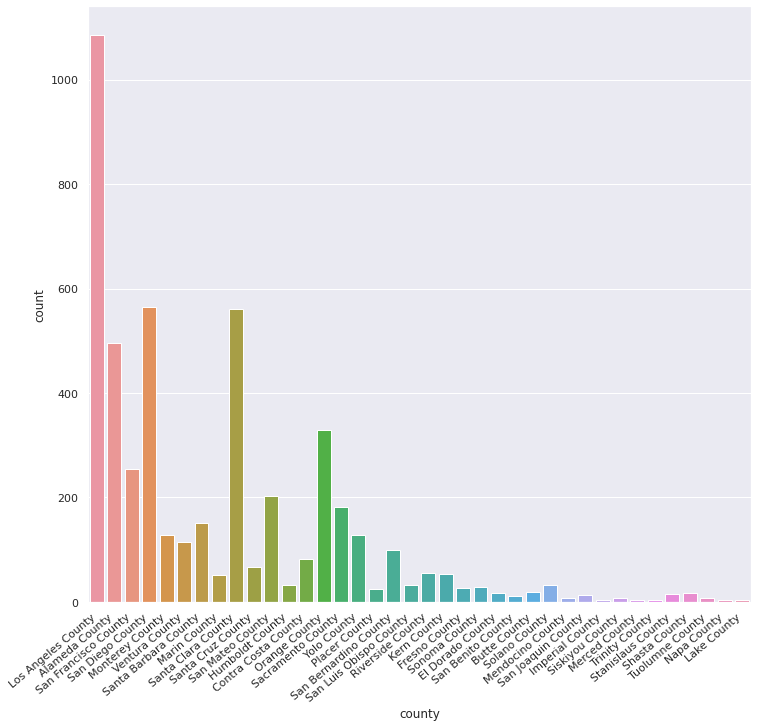

Number of residents in the county Los Angeles County: 1086
Number of residents in the county Alameda County: 495
Number of residents in the county San Francisco County: 255
Number of residents in the county San Diego County: 565
Number of residents in the county Monterey County: 128
Number of residents in the county Ventura County: 114
Number of residents in the county Santa Barbara County: 151
Number of residents in the county Marin County: 52
Number of residents in the county Santa Clara County: 560
Number of residents in the county Santa Cruz County: 67
Number of residents in the county San Mateo County: 202
Number of residents in the county Humboldt County: 32
Number of residents in the county Contra Costa County: 83
Number of residents in the county Orange County: 330
Number of residents in the county Sacramento County: 182
Number of residents in the county Yolo County: 129
Number of residents in the county Placer County: 24
Number of residents in the county San Bernardino County:

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(10.7, 10.27)
ax = sns.countplot(x="county", data=bank_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()


for county in bank_data["county"].unique():
    print(f"Number of residents in the county {county}: {len(bank_data[(bank_data.county == county)])}")

# Filtering out certain counties
- As seen in the plot above, some counties have minimal count of people 
- Considering counties with less people might lead to partial learning
- Hence **we will only keep counties with more than 30 residents.**

In [14]:
# please read the above cell for more info

# keep track of counties which has more than 30 residents.
counties_to_keep = []
for county in bank_data["county"].unique():
    if len(bank_data[(bank_data.county == county)])>30:
        counties_to_keep.append(county)

# only keep track of residents in those counties
residents_to_keep=[]
for idx, resident in bank_data.iterrows():
    if resident["county"] in counties_to_keep:
        residents_to_keep.append(idx)
        
# filtering out the desired residents
bank_data = bank_data.loc[residents_to_keep]

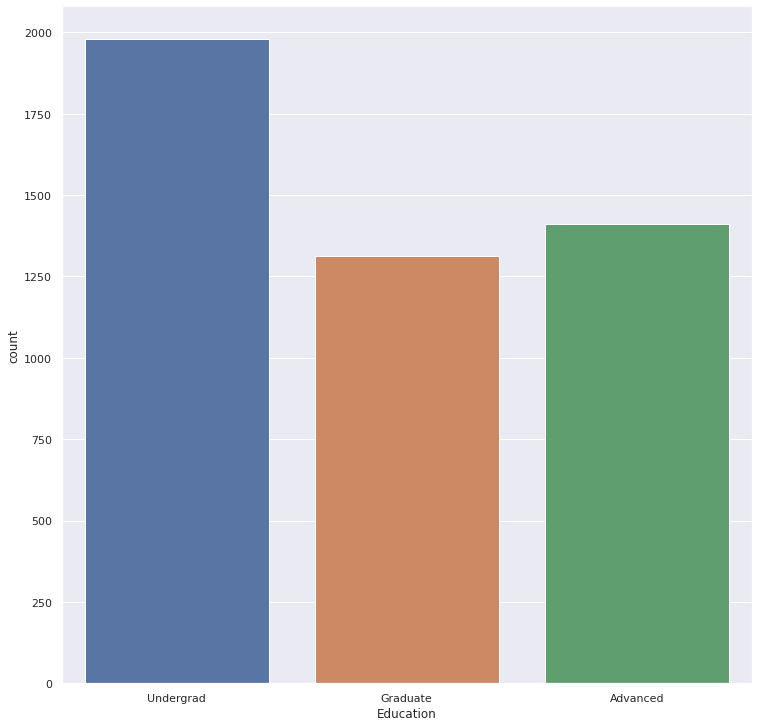

Number of residents in the Education level Undergrad: 1981
Number of residents in the Education level Graduate: 1312
Number of residents in the Education level Advanced: 1411


In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(10.7, 10.27)
ax = sns.countplot(x="Education", data=bank_data)
ax.set_xticklabels(ax.get_xticklabels())
plt.tight_layout()
plt.show()


for education in bank_data["Education"].unique():
    print(f"Number of residents in the Education level {education}: {len(bank_data[(bank_data.Education == education)])}")

Univariate Analysis of Age
Max age is 67
Min age is 24
Mean age is 45.60735544217687


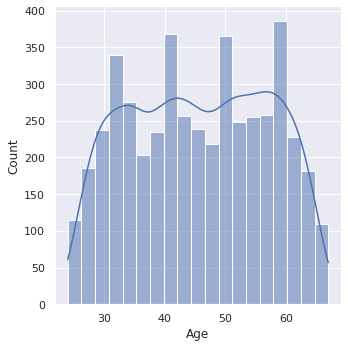

In [16]:
print("Univariate Analysis of Age")
ages = bank_data.Age
sns.displot(ages,kde=True);
print(f"Max age is {np.max(ages)}")
print(f"Min age is {np.min(ages)}")
print(f"Mean age is {np.mean(ages)}")

Univariate Analysis of Experience
Max experience is 43
Min experience is 0
Mean experience is 20.382653061224488


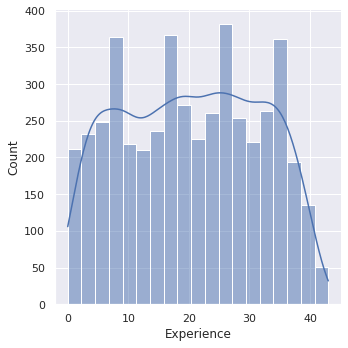

In [17]:
print("Univariate Analysis of Experience")
experiences = bank_data.Experience
sns.displot(experiences,kde=True);
print(f"Max experience is {np.max(experiences)}")
print(f"Min experience is {np.min(experiences)}")
print(f"Mean experience is {np.mean(experiences)}")

Univariate Analysis of CCAvg column
Max credit spending per month is 10000.0 dollars
Min credit spending per month is 0.0 dollars
Mean credit spending per month is 1939.7130102040858dollars


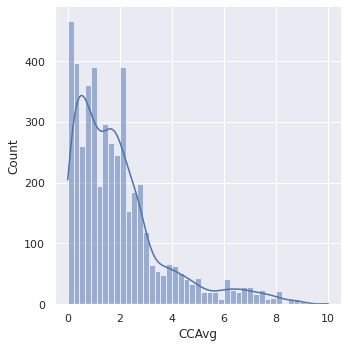

In [18]:
print("Univariate Analysis of CCAvg column")
credit_spendings = bank_data.CCAvg
sns.displot(credit_spendings,kde=True);
print(f"Max credit spending per month is {np.max(credit_spendings)*1000} dollars")
print(f"Min credit spending per month is {np.min(credit_spendings)*1000} dollars")
print(f"Mean credit spending per month is {np.mean(credit_spendings)*1000}dollars")

Univariate Analysis of CCAvg column
Max mortage is 635000 dollars
Min mortage is 0 dollars
Mean mortage is 56410.07653061224dollars


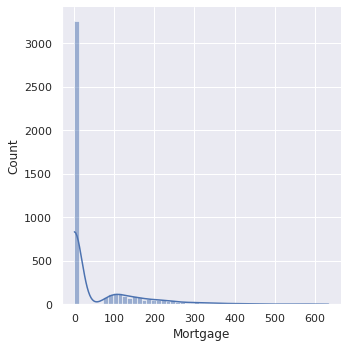

In [19]:
print("Univariate Analysis of CCAvg column")
mortages = bank_data.Mortgage
sns.displot(mortages,kde=True);

print(f"Max mortage is {np.max(mortages)*1000} dollars")
print(f"Min mortage is {np.min(mortages)*1000} dollars")
print(f"Mean mortage is {np.mean(mortages)*1000}dollars")

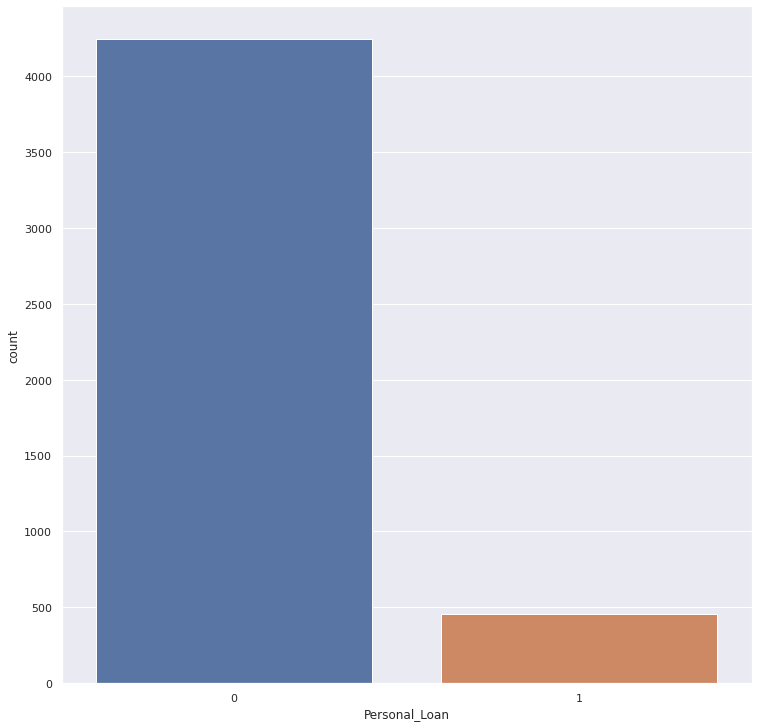

Number of residents of 0 loan status: 4246
Number of residents of 1 loan status: 458


In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(10.7, 10.27)
ax = sns.countplot(x="Personal_Loan", data=bank_data)
ax.set_xticklabels(ax.get_xticklabels())
plt.tight_layout()
plt.show()


for loan in bank_data["Personal_Loan"].unique():
    print(f"Number of residents of {loan} loan status: {len(bank_data[(bank_data.Personal_Loan == loan)])}")

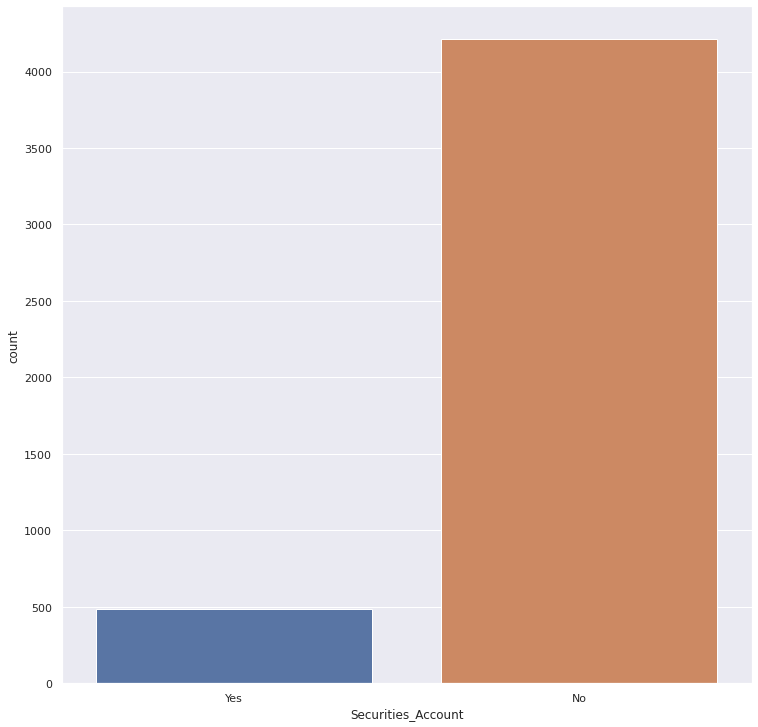

Number of residents with security account : 488
Number of residents with no security account : 4216


In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(10.7, 10.27)
ax = sns.countplot(x="Securities_Account", data=bank_data)
ax.set_xticklabels(ax.get_xticklabels())
plt.tight_layout()
plt.show()


for account_status in bank_data["Securities_Account"].unique():
    if account_status=="Yes":
        print(f"Number of residents with security account : {len(bank_data[(bank_data.Securities_Account == account_status)])}")
    if account_status=="No":
        print(f"Number of residents with no security account : {len(bank_data[(bank_data.Securities_Account == account_status)])}")

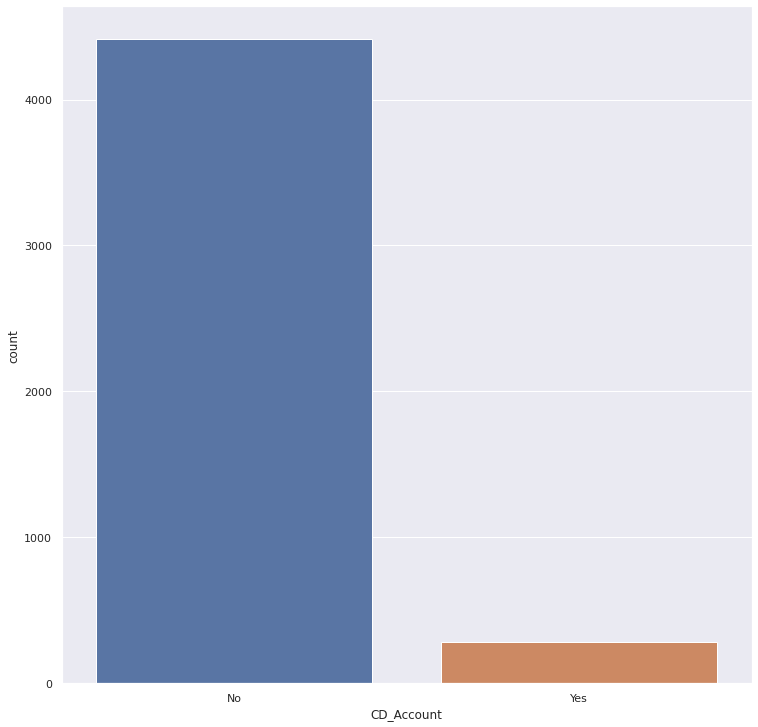

Number of residents with no CD account : 4216
Number of residents with CD account : 488


In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(10.7, 10.27)
ax = sns.countplot(x="CD_Account", data=bank_data)
ax.set_xticklabels(ax.get_xticklabels())
plt.tight_layout()
plt.show()


for account_status in bank_data["CD_Account"].unique():
    if account_status=="Yes":
        print(f"Number of residents with CD account : {len(bank_data[(bank_data.Securities_Account == account_status)])}")
    if account_status=="No":
        print(f"Number of residents with no CD account : {len(bank_data[(bank_data.Securities_Account == account_status)])}")

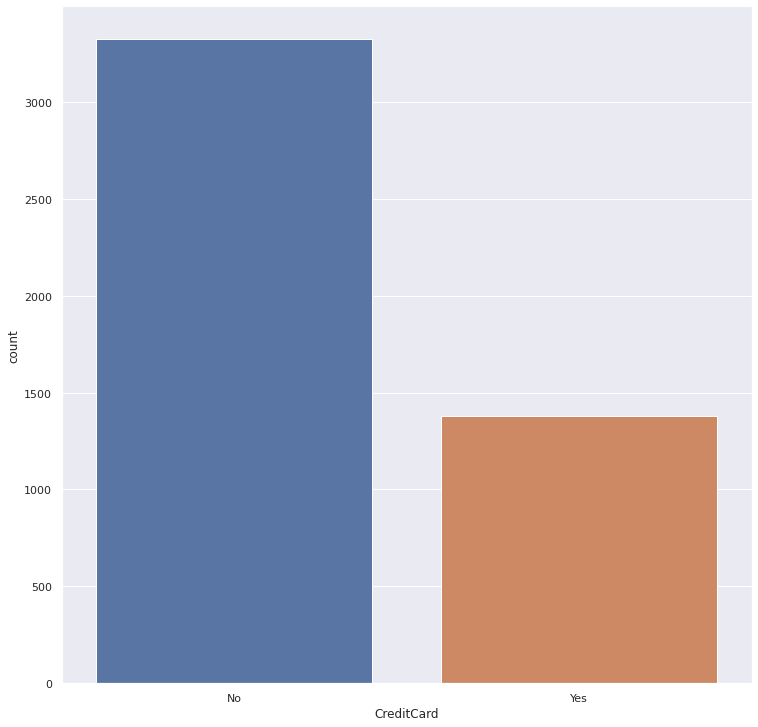

Number of residents with no Online operation : 4216
Number of residents with Online operation : 488


In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(10.7, 10.27)
ax = sns.countplot(x="CreditCard", data=bank_data)
ax.set_xticklabels(ax.get_xticklabels())
plt.tight_layout()
plt.show()


for account_status in bank_data["CreditCard"].unique():
    if account_status=="Yes":
        print(f"Number of residents with Online operation : {len(bank_data[(bank_data.Securities_Account == account_status)])}")
    if account_status=="No":
        print(f"Number of residents with no Online operation : {len(bank_data[(bank_data.Securities_Account == account_status)])}")

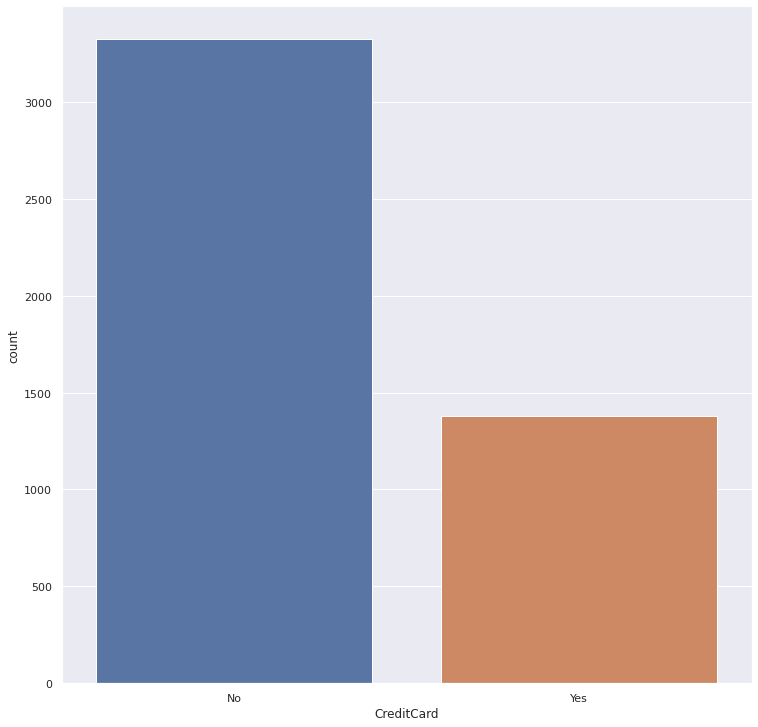

Number of residents who does not use other credit cards : 4216
Number of residents who use other credit cards : 488


In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(10.7, 10.27)
ax = sns.countplot(x="CreditCard", data=bank_data)
ax.set_xticklabels(ax.get_xticklabels())
plt.tight_layout()
plt.show()


for account_status in bank_data["CreditCard"].unique():
    if account_status=="Yes":
        print(f"Number of residents who use other credit cards : {len(bank_data[(bank_data.Securities_Account == account_status)])}")
    if account_status=="No":
        print(f"Number of residents who does not use other credit cards : {len(bank_data[(bank_data.Securities_Account == account_status)])}")

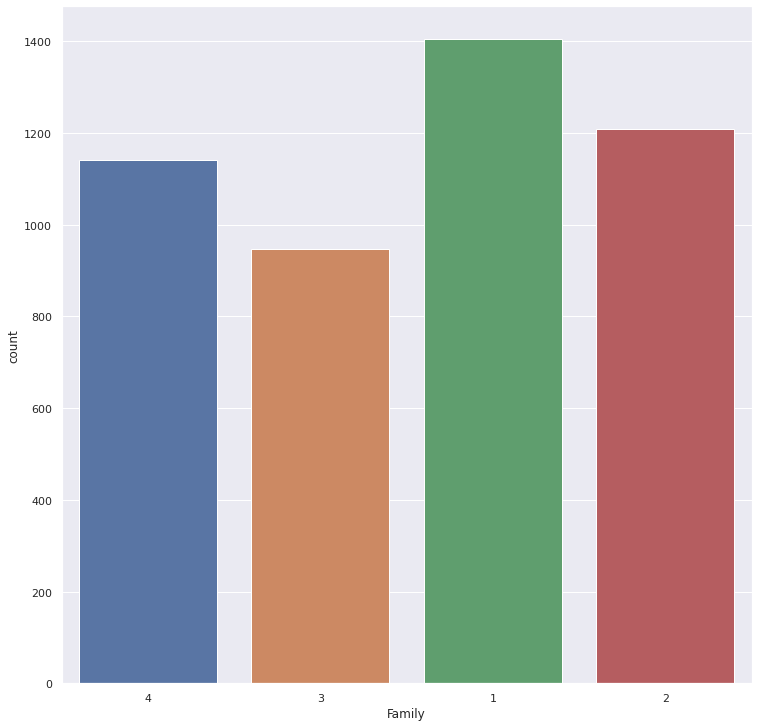

Number of residents with 4 family count: 1142
Number of residents with 3 family count: 948
Number of residents with 1 family count: 1406
Number of residents with 2 family count: 1208


In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(10.7, 10.27)
ax = sns.countplot(x="Family", data=bank_data)
ax.set_xticklabels(ax.get_xticklabels())
plt.tight_layout()
plt.show()


for family_count in bank_data["Family"].unique():
    print(f"Number of residents with {family_count} family count: {len(bank_data[(bank_data.Family == family_count)])}")

# Bi-Variate Analysis

<AxesSubplot:>

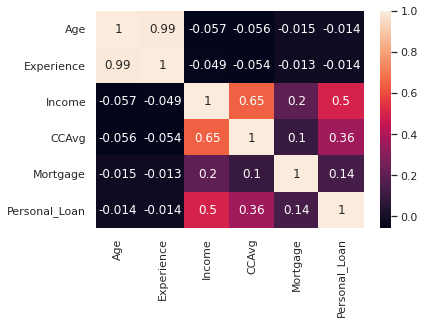

In [26]:
sns.heatmap(bank_data.corr(), annot=True)  # plot the correlation coefficients 

## Some observations from the cross correlation plot above

- As expected there is a strong +ve correlation between Age and Experience
- Income and Credit card usage has good +ve correlation as well
- Also mild strong +ve correlation between Income and Personal_loan (more income more likely (and confident
  to open the loan)
- Slightly better +ve correlation between Credit card usage and opening a loan
- Little +ve correlation between Mortgage spent and income (which is expected)

In [27]:
bank_data.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,county
0,25,1,49,4,1.6,Undergrad,0,0,Yes,No,No,No,Los Angeles County
1,45,19,34,3,1.5,Undergrad,0,0,Yes,No,No,No,Los Angeles County
2,39,15,11,1,1.0,Undergrad,0,0,No,No,No,No,Alameda County
3,35,9,100,1,2.7,Graduate,0,0,No,No,No,No,San Francisco County
4,35,8,45,4,1.0,Graduate,0,0,No,No,No,Yes,Los Angeles County


## Studying Age and Experience

### Some observations from the plot below:

- As expected with age, the experience increases (if the person is still employed)

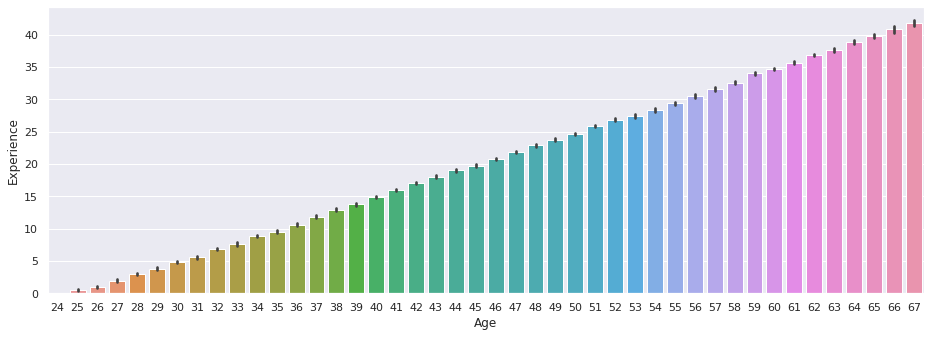

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(15.7, 5.27)
ax = sns.barplot(x=bank_data['Age'], y=bank_data['Experience'])

## Studying Age and credit card spending

### Some observations from the plot below:

- People of age 26 seems to be spending the most
- People of age 66 seems to be spending the least

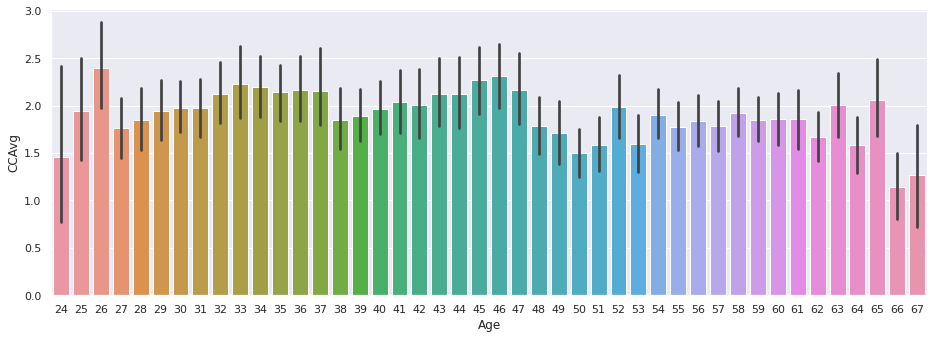

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(15.7, 5.27)
ax = sns.barplot(x=bank_data['Age'], y=bank_data['CCAvg'])

## Studying between Personal loan and Income

### Some observations from the plot below:

- People of higher income as mostly the ones takes on the loan.

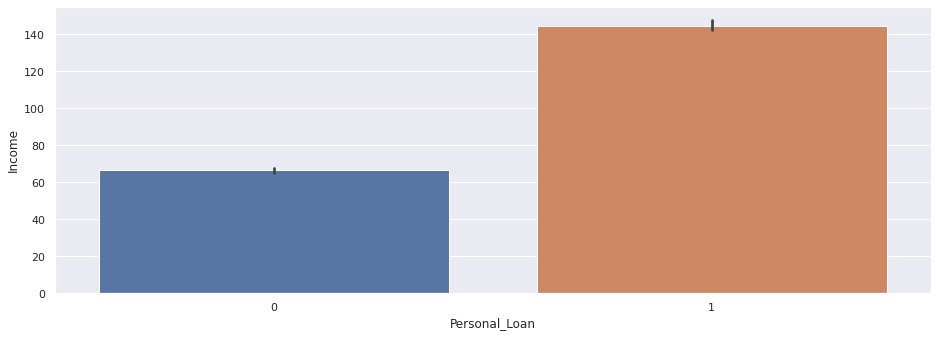

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(15.7, 5.27)
ax = sns.barplot(x=bank_data['Personal_Loan'], y=bank_data['Income'])

## Studying between Personal loan and county

### Some observations from the plot below:

- Folks from Contra cost county, San Luis Obispo county, kern county, santa clara county and Monterey county
  have opted for loans in past.
- Folks from San Bernadino county, San fransico county, san mateo county and santa barbara county are less likely to  go for a loan.

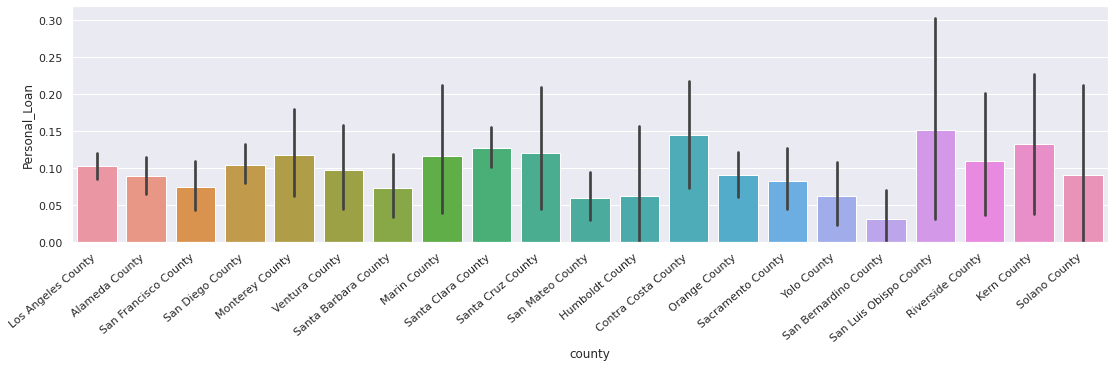

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(15.7, 5.27)
ax = sns.barplot(y=bank_data['Personal_Loan'], x=bank_data['county'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

## Studying between Personal loan and family

### Some observations from the plot below:

- A family of 4 and 3 are most likely to take the loan as opposed to just 1 and 2.
- This makes sense as it is expected to have a separate room for children in certain counties.

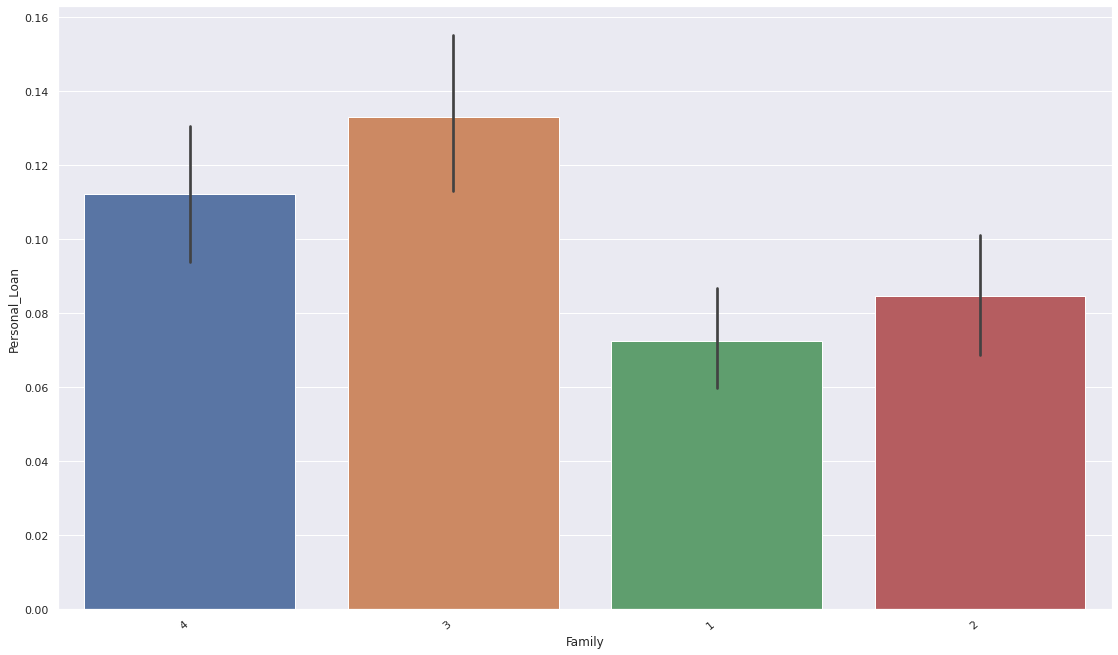

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(15.7, 9.27)
ax = sns.barplot(y=bank_data['Personal_Loan'], x=bank_data['Family'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

## Studying between Education and Personal loan

### Some observations from the plot below:

- Personal loans are taken by Advanced and graduate level degree holders
- Under grads are the least to take the loan

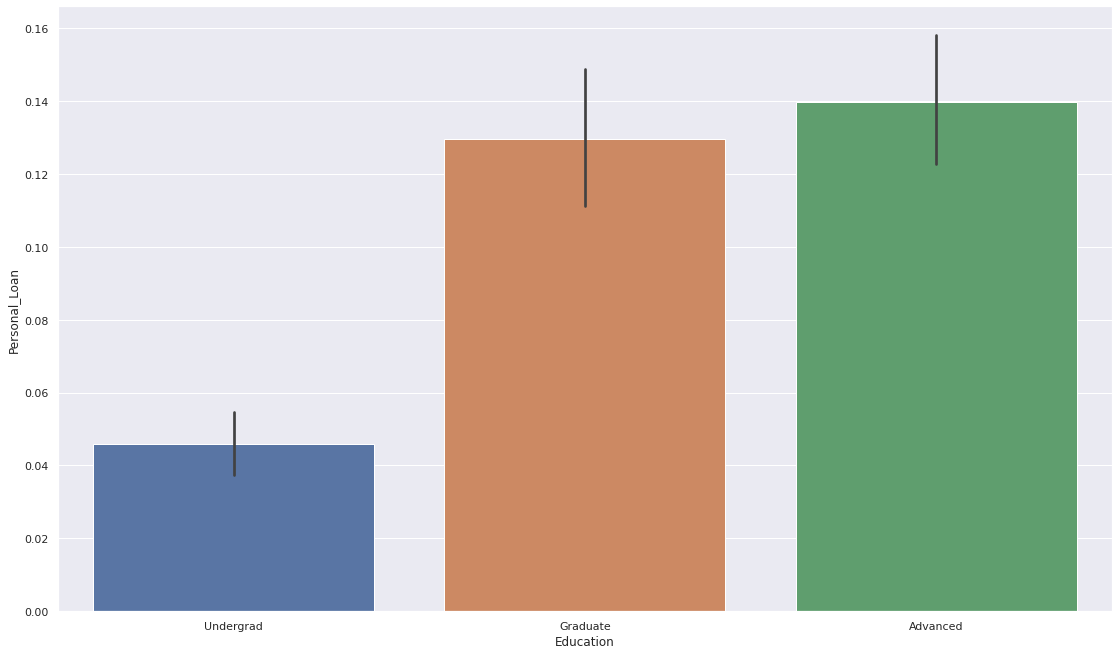

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(15.7, 9.27)
ax = sns.barplot(y=bank_data['Personal_Loan'], x=bank_data['Education'])
plt.tight_layout()

## Studying between Income and Education

### Some observations from the plot below:

- Undergrads are earning higher than grads and advanced degree holder (might be due to more years of experience)

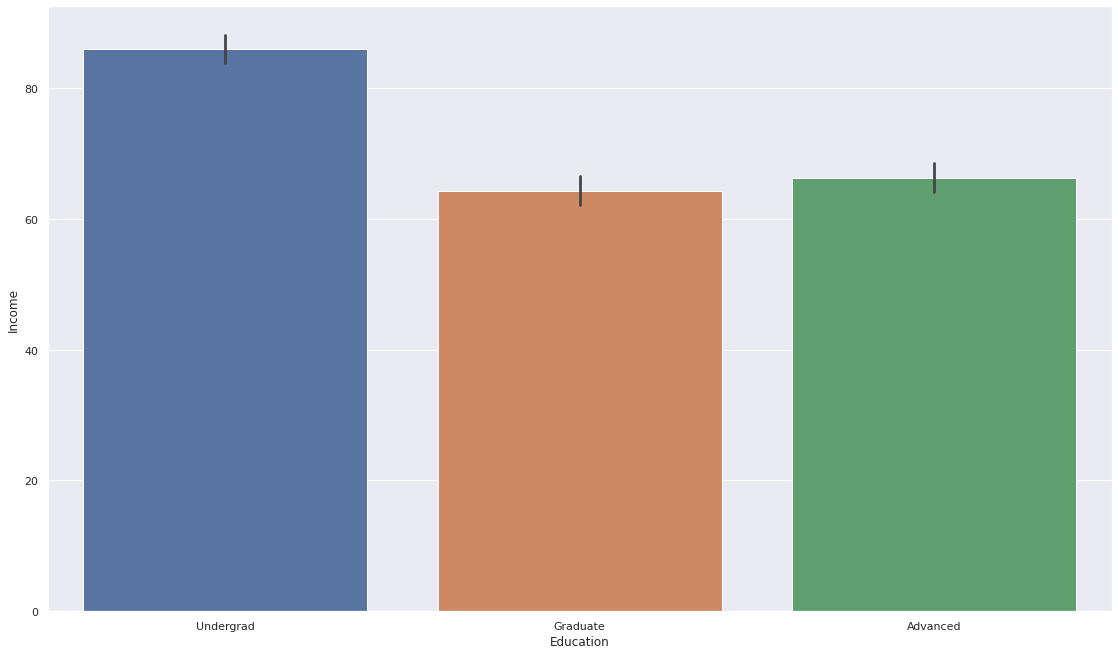

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(15.7, 9.27)
ax = sns.barplot(y=bank_data['Income'], x=bank_data['Education'])
plt.tight_layout()

## Studying between Personal loan and securities account

### Some observations from the plot below:

- People who have the securities account have accpeted to go for a loan.

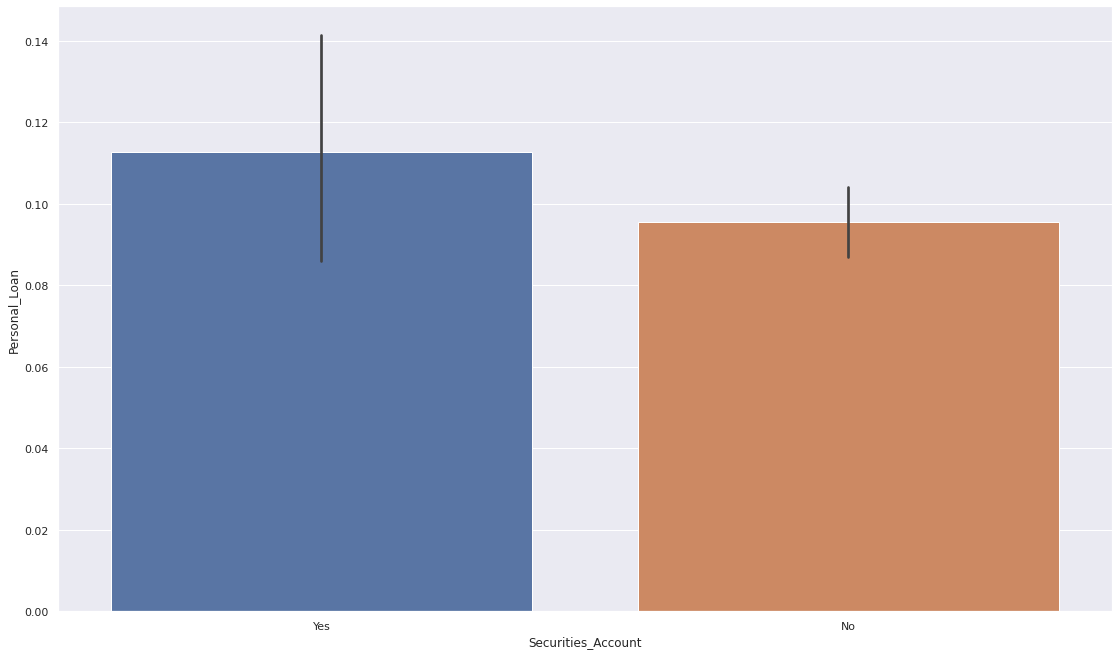

In [35]:
fig, ax = plt.subplots()
fig.set_size_inches(15.7, 9.27)
ax = sns.barplot(y=bank_data['Personal_Loan'], x=bank_data['Securities_Account'])
plt.tight_layout()

## Studying between Personal loan and CD account

### Some observations from the plot below:

- It is very obvious from the plot below that people who have a CD account have opted for a loan.

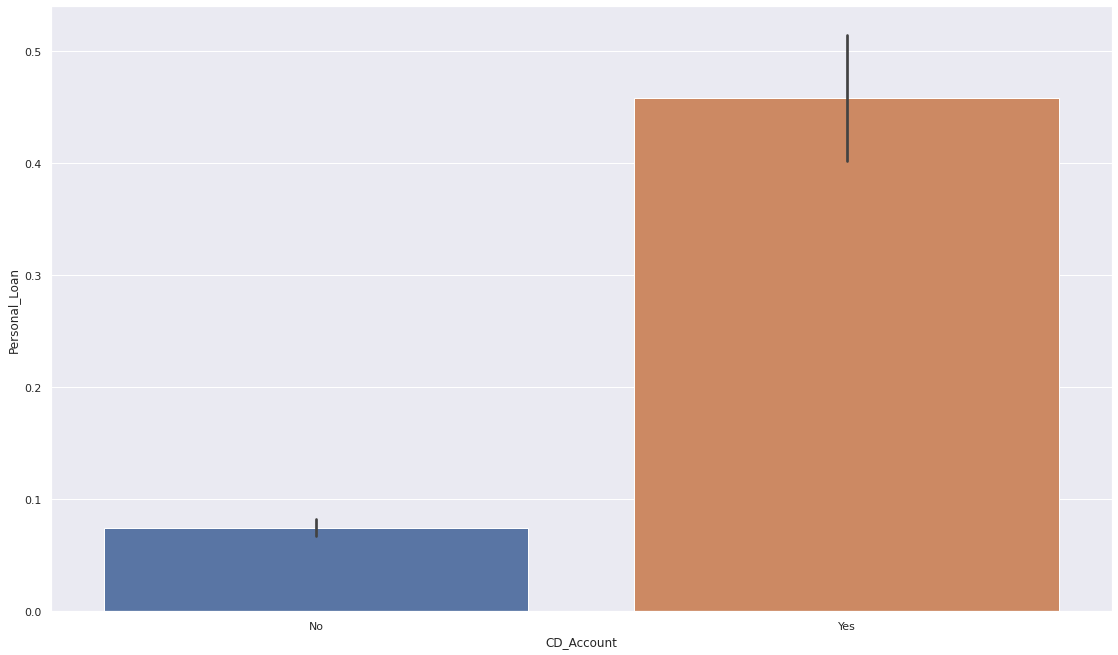

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(15.7, 9.27)
ax = sns.barplot(y=bank_data['Personal_Loan'], x=bank_data['CD_Account'])
plt.tight_layout()

## Studying between county and mortgage

### Some observations from the plot below:

- Folks from Santa barbara county, santa cruz, san bernadino county,sacremento county, san fransico county have
  high mortgages.
- Folks from the san luis obispo county, marin and Humbold county has the least mortgages.

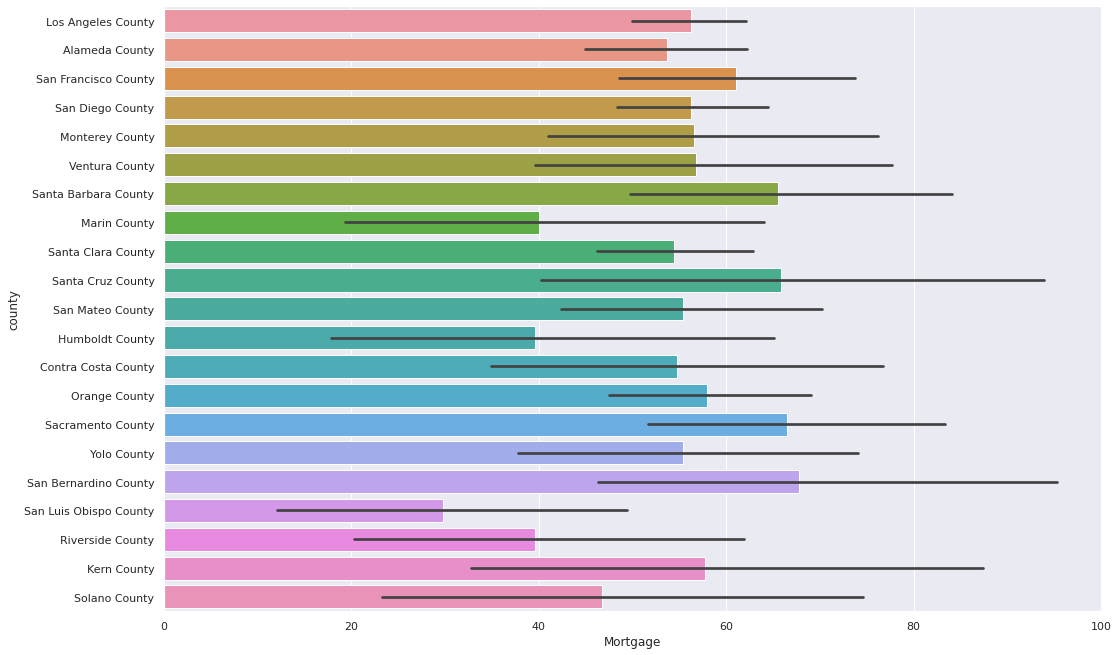

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(15.7, 9.27)
ax = sns.barplot(y=bank_data['county'], x=bank_data['Mortgage'])
plt.tight_layout()

## Studying between credit card usage and personal loan

### Some observations from the plot below:

- Folks with higher usage of card tend to open an loan.
- Folks with lower usage do not tend to open the loan.

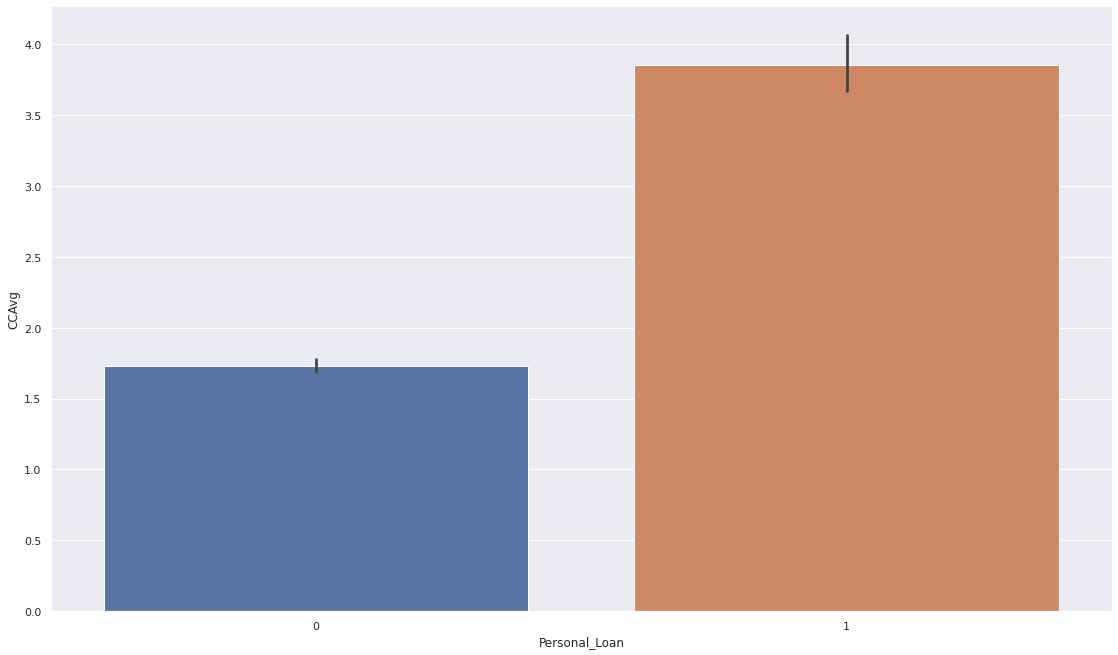

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(15.7, 9.27)
ax = sns.barplot(x=bank_data['Personal_Loan'], y=bank_data['CCAvg'])
plt.tight_layout()

## Studying between online user and loan

### Some observations from the plot below:

- Folks with online account opened have little higher probability to open personal loan/


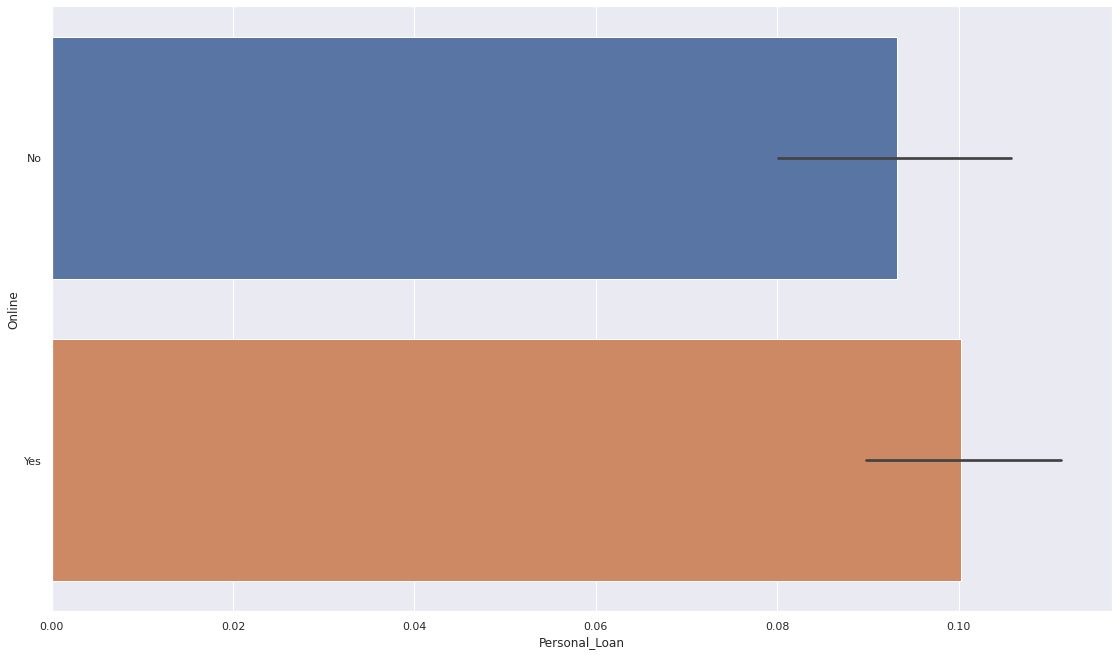

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(15.7, 9.27)
ax = sns.barplot(x=bank_data['Personal_Loan'], y=bank_data['Online'])
plt.tight_layout()

## Studying between credit card user (from other bank) and personal loan

### Some observations from the plot below:

-Does not have strong correlation here, seems like irrespective of credit cards usage (from us or 
other banks), people open loan.


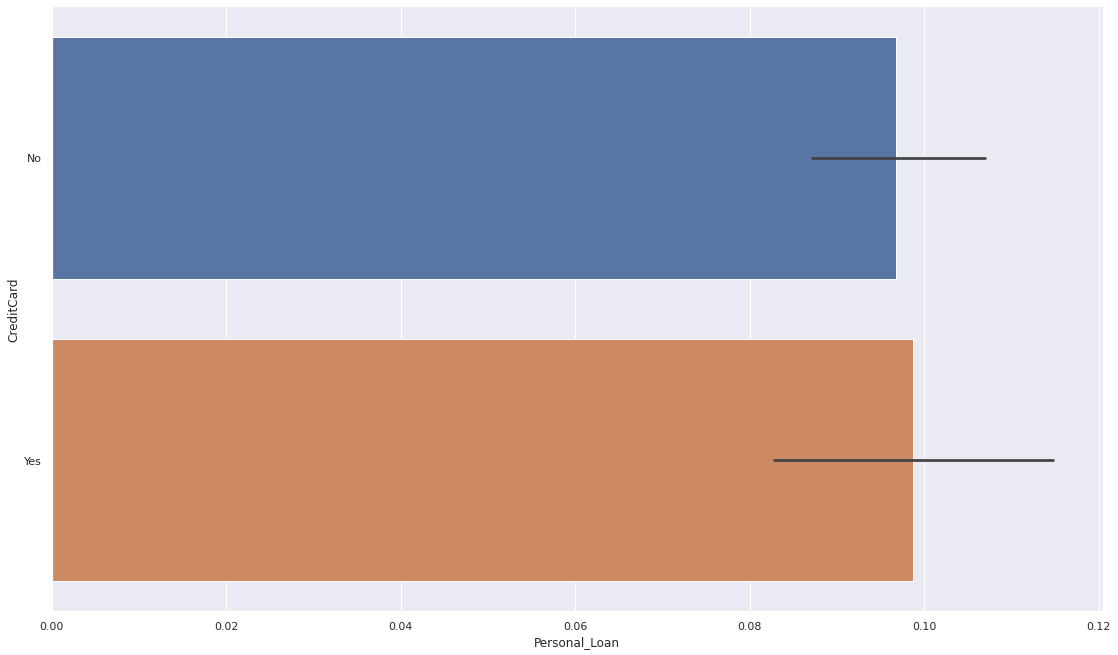

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(15.7, 9.27)
ax = sns.barplot(x=bank_data['Personal_Loan'], y=bank_data['CreditCard'])
plt.tight_layout()

## Studying between income and personal loan

### Some observations from the plot below:

- Apparently folks with higher income are most likely to open a personal loan.


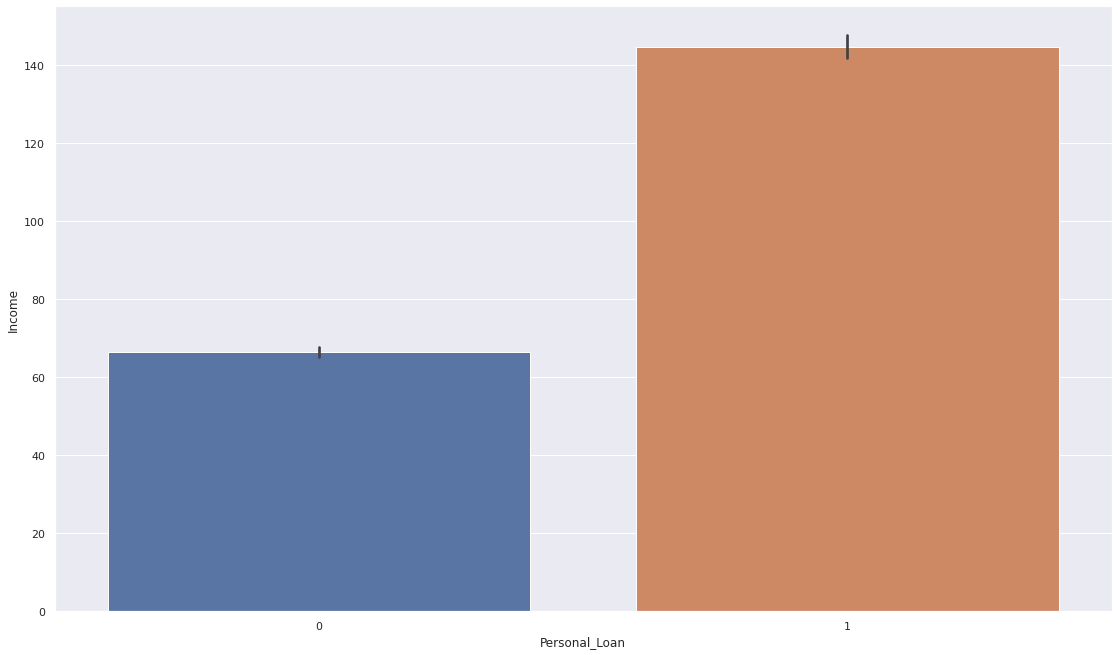

In [41]:
fig, ax = plt.subplots()
fig.set_size_inches(15.7, 9.27)
ax = sns.barplot(x=bank_data['Personal_Loan'], y=bank_data['Income'])
plt.tight_layout()

# Handling skewness for some of the fields

- Before we go to town for building the model, we need to handle some of the skewness in the dataset.
- As **seen below**, the "Income", "CCAvg" and "Mortgage" fields are skewed.
- we should ignore the Personal_loan (as that is our target column (to build the model)


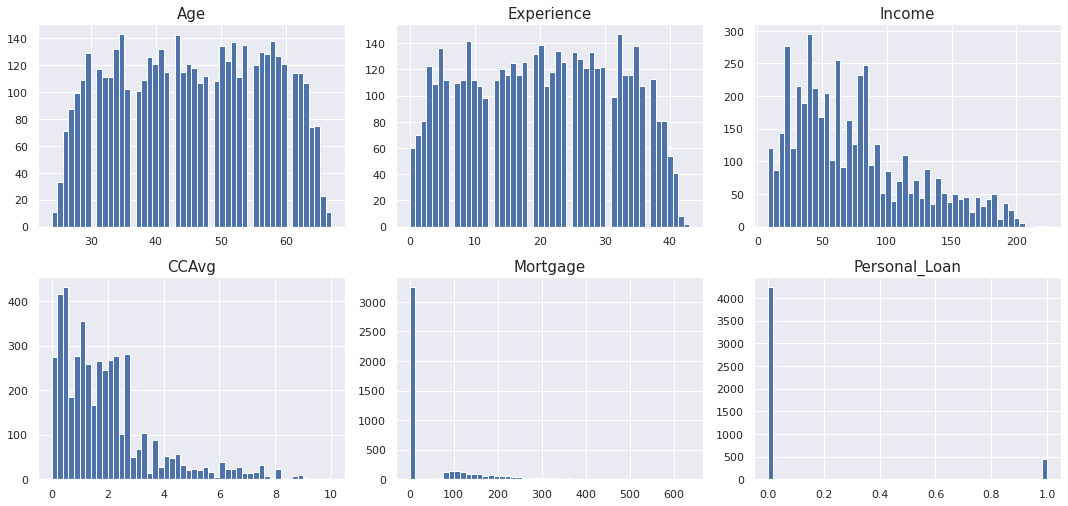

In [42]:
# creating a list of numerical columns
num_cols = [
    num_col for num_col in bank_data.select_dtypes(include=np.number).columns
]

plt.figure(figsize=(15, 35))

# then plot the numerical columns.
for i in range(len(num_cols)):
    plt.subplot(10, 3, i + 1)
    plt.hist(bank_data[num_cols[i]], bins=50)
    plt.tight_layout()
    plt.title(num_cols[i], fontsize=15)

plt.show()

# Applying the log transform for "Income", "CCAvg" and "Mortgage" fields


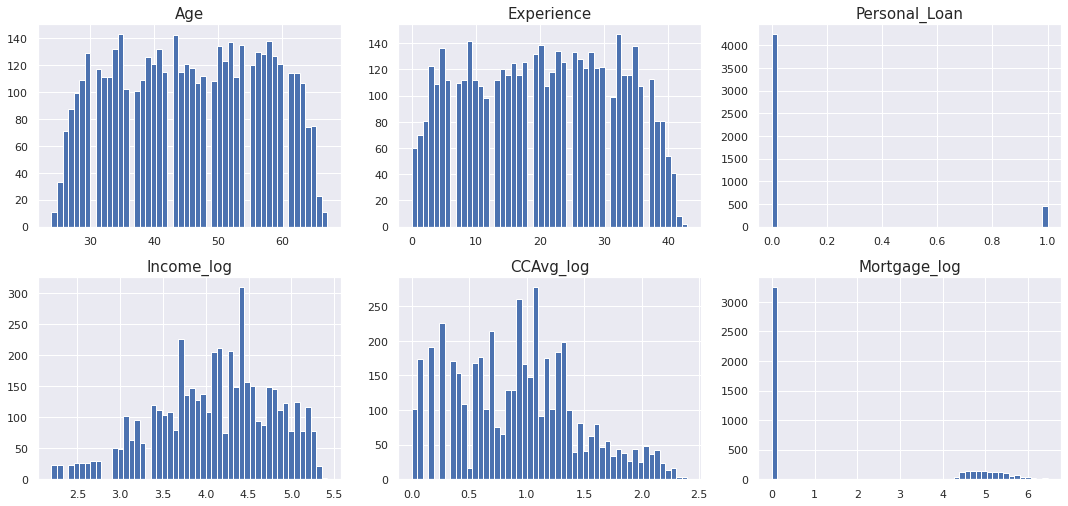

In [43]:
# creating a copy of the dataframe, this copy will be specifically used for building the regression model
bank_data_skew_fixed = bank_data.copy()

# these are less skewed and no need to apply log on it and Personal_Loan is our target variable
num_cols.remove("Personal_Loan") 
num_cols.remove("Age")
num_cols.remove("Experience")


# using log transforms on some columns
for col in num_cols:
    bank_data_skew_fixed[col + "_log"] = np.log(bank_data_skew_fixed[col] + 1)


# drop the original numerical columns and use the log ones.
bank_data_skew_fixed.drop(num_cols, axis=1, inplace=True)

# creating a list of numerical columns with log transform applied.
num_cols = [
    num_col for num_col in bank_data_skew_fixed.select_dtypes(include=np.number).columns
]

plt.figure(figsize=(15, 35))

for i in range(len(num_cols)):
    plt.subplot(10, 3, i + 1)
    plt.hist(bank_data_skew_fixed[num_cols[i]], bins=50)
    plt.tight_layout()
    plt.title(num_cols[i], fontsize=15)

plt.show()

In [44]:
# Set the feature vectors
X = bank_data_skew_fixed.drop(["Personal_Loan"], axis=1)
# Set the target variable
Y = bank_data_skew_fixed["Personal_Loan"]

X = pd.get_dummies(X, drop_first=True)

# Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=1
)
# Print some meta of the training and testing data.
print_training_testing_meta(X_train=X_train,
                            X_test=X_test,
                            y_train=y_train,
                            y_test=y_test)


Shape of Training set : (3292, 34)
Shape of test set : (1412, 34)
Percentage of classes in training set:0    0.902795
1    0.097205
Name: Personal_Loan, dtype: float64
Percentage of classes in test set:0    0.902266
1    0.097734
Name: Personal_Loan, dtype: float64


In [45]:
# Now build the model
lg = LogisticRegression(solver="newton-cg", random_state=1)
model = lg.fit(X_train, y_train)

In [46]:
coef_df = pd.DataFrame(
    np.append(lg.coef_, lg.intercept_),
    index=X_train.columns.tolist() + ["Intercept"],
    columns=["Coefficients"],
)
coef_df

,Coefficients
Age,0.003377
Experience,-0.000676
Income_log,6.125031
CCAvg_log,0.947427
Mortgage_log,0.071345
Family_2,-0.273237
Family_3,1.614525
Family_4,1.164319
Education_Graduate,0.065733
Education_Undergrad,-3.237454


## Coefficient interpretation
- As seen above increasing age, experience, family 1 or 2, undergrad education only, folks with security account 
  negatively affects the model (decreases the possbility of a person getting the loan)
- if residing in Ventura, santa clara, santa barbara, sacremento, monterey etc, if family of 3 and 4, if with a CD account, with higher credit card usage and higher income increases the probablity of getting a loan.

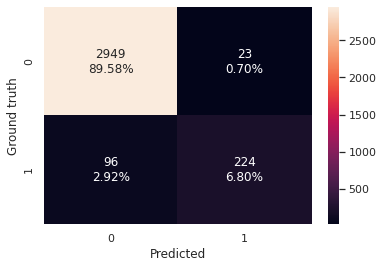

In [47]:
# confusion matrix for the training set
plot_confusion_matrix(model=lg, features=X_train, target=y_train)

In [48]:
print("Training performance:")
print_model_performance_for_classification(model=lg, 
                                           features=X_train, 
                                           target=y_train)




Training performance:
Accuracy:0.9638517618469016
Recall:0.7
Precision: 0.9068825910931174
F1 score: 0.7901234567901235


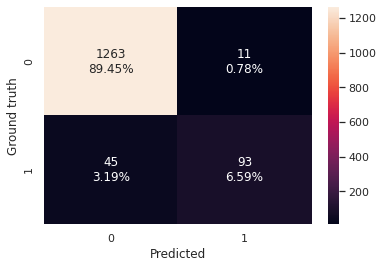

In [49]:
# confusion matrix for the testing set
plot_confusion_matrix(model=lg, features=X_test, target=y_test)

In [50]:
print("Test performance:")
print_model_performance_for_classification(model=lg, 
                                           features=X_test, 
                                           target=y_test)

Test performance:
Accuracy:0.9603399433427762
Recall:0.6739130434782609
Precision: 0.8942307692307693
F1 score: 0.768595041322314


# Improving the Recall score

## Why is it important?
The model having a low TPR (true positive rate) score is a problem because:
- This leads to increase in FN (people predicted not opting for a loan, but the truth is they did opt for a loan).
- Cost of **not reaching out to a person** (who has a high probability of accepting a loan) is higher, as this means we lost a potential client.
- Cost of **reaching out to a person** (who has a less probability of accepting a loan) is not that expensive (as it will be a few minutes of lost customer interaction).
- Hence we need to get the **recall** higher. 

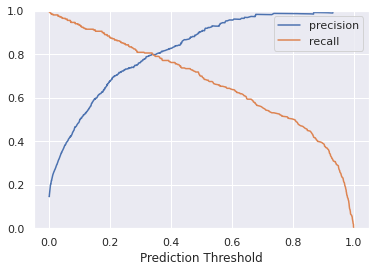

In [51]:
y_scores = lg.predict_proba(X_train)[:, 1]
plot_precision_recall_threshold(y_train, y_scores)

### As seen in the plot *above* arond threshold of 0.317, we will get a better recall and precision score

In [52]:
print("Training performance with the threshold inferred from the plot above:")
desired_threshold = 0.317
print_model_performance_for_classification(model=lg, 
                                           features=X_train, 
                                           target=y_train,
                                           threshold=desired_threshold)
print("")
print("Test performance with the threshold inferred from the plot above:")
print_model_performance_for_classification(model=lg, 
                                           features=X_test, 
                                           target=y_test,
                                           threshold=desired_threshold)

Training performance with the threshold inferred from the plot above:
Accuracy:0.9592952612393681
Recall:0.80625
Precision: 0.7818181818181819
F1 score: 0.7938461538461539

Test performance with the threshold inferred from the plot above:
Accuracy:0.9624645892351275
Recall:0.8115942028985508
Precision: 0.8057553956834532
F1 score: 0.808664259927798


### As we see *above*, the recall score has gotten better (better than the training data) and the harmonic mean (the f1 score) is also better in testing (little better than the training data)

# Decision tree model building and prunning

In [53]:
# make a decision tree model 
decision_tree = DecisionTreeClassifier(criterion = 'gini',random_state=1)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [54]:
print("Training data performance with the decision tree model")
print_model_performance_for_classification(model=decision_tree, 
                                           features=X_train, 
                                           target=y_train)

print("")
print("Test data performance with the decision tree model")
print_model_performance_for_classification(model=decision_tree, 
                                           features=X_test, 
                                           target=y_test)

Training data performance with the decision tree model
Accuracy:1.0
Recall:1.0
Precision: 1.0
F1 score: 1.0

Test data performance with the decision tree model
Accuracy:0.9780453257790368
Recall:0.9057971014492754
Precision: 0.8741258741258742
F1 score: 0.8896797153024912


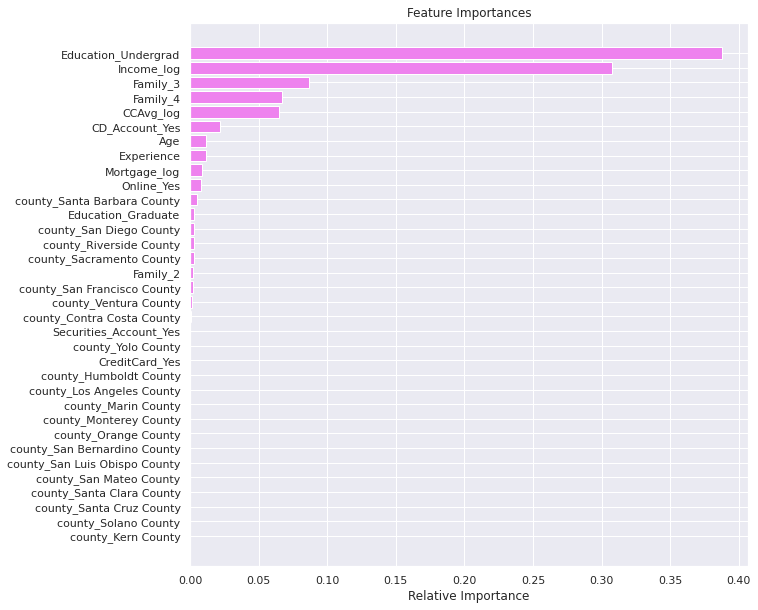

In [55]:
plot_features_importances(feature_names=list(X.columns),decision_tree=decision_tree)

# Performance before prunning
- The recall score is good for the **test** data (around ~90.5 %) and the F1 score is 88.9%.
- As pe the plot above, the most important feature is education field.
- Let's do pre prunning and see if it helps.

In [56]:
prunned_tree = perform_pre_prunning(X_train=X_train,y_train=y_train)

In [57]:
print("Test data performance with the prunned decision tree model")
print_model_performance_for_classification(model=prunned_tree, 
                                           features=X_test, 
                                           target=y_test)

Test data performance with the prunned decision tree model
Accuracy:0.9858356940509915
Recall:0.9420289855072463
Precision: 0.9154929577464789
F1 score: 0.9285714285714286


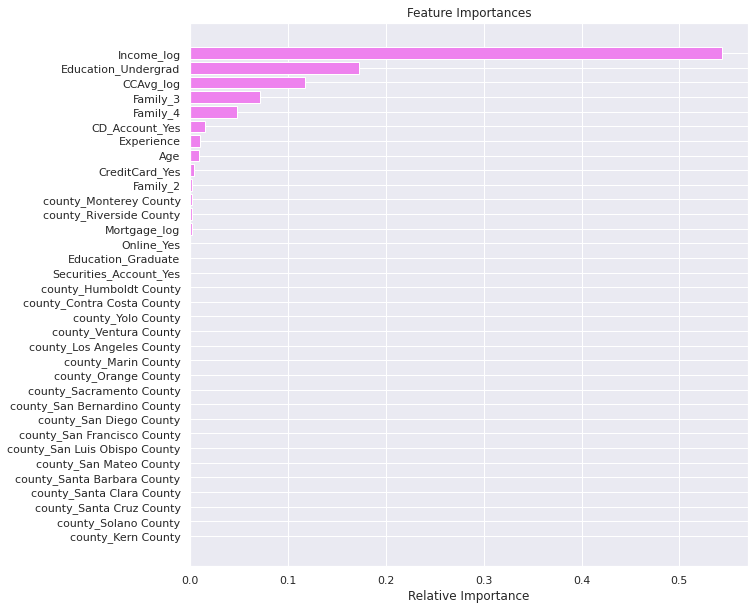

In [58]:
plot_features_importances(feature_names=list(X.columns),decision_tree=prunned_tree)

# Performance after prunning
- The recall score got better for the **test** data (around ~94.2 %) and the F1 score is 92.8%. (which is great!!)
- Almost the most important feature (after prunning) came out to be Income field.
- **It is recommended to use this pre prunned tree for our business**.

# Between the logistic regreesion and the decision tree (and advice for the marketting team on how to use these)

- Both the models have good recall (which is what we care most) and overall scores.
- But the decision tree has much better scores and will be most recommended for usage by the marketting team
- An other thought would be use to both the models when querying about a resident, and then use the 
  consensus score. 
- If both the models are giving good score (>=70 %), then the team should reach out to that person. 

# Take away for the marketting team

- The team should immediately reach out to all current customers with CD account.
- Especially make it a top priority to reach out to CD account customers in Contra cost county, San Luis Obispo county, kern county, santa clara county and Monterey county
- Also reachout for all of our customers with **higher income** (and especially with a family 3 or 4)
- For the folks who have not opened a CD account, send out an email of plan of our new account options. will be good to convert them to longer term customers.
- Reach out to couples and single customers with **high credit card usage** and advertise our special townhouse loan program (as that is attactive to couples and single people these days)
- Graduate degree holder and advanced degree holders with a family of 3 and 4 are a very target too, will be good to reach out to them as well